# Introduction

This notebook introduces the OpenKMI package. OpenKMI serves as a wrapper around the WFS and WMS service that KMI offers to download synoptic measurements, data from the automatic weather stations and ALARO forecasts.

This notebook focuses on the Alaro forecasts.

https://opendata.meteo.be/geonetwork/srv/eng/catalog.search;jsessionid=1A4FC7644B7C0B8D17287BA7A9A21278#/metadata/RMI_DATASET_ALARO


# Initialize the package

First load the modules we will use

In [26]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd   
from openkmi.grid_data import Alaro
from openkmi.point_obs import AWS
from datetime import datetime, timedelta

Then initialize the package. 

In [2]:
kmi = Alaro()

# Inspect the available data

You can use OpenKMI to get an overview of all layers (parameters) where we have forecasts for

In [3]:
layers = kmi.get_layers()
print(layers)

['10_m_u__wind_component', '10_m_v__wind_component', '2_m_Max_temp_since_ppp', '2_m_Min_temp_since_ppp', '2_m_dewpoint_temperature', '2_m_temperature', '2m_Relative_humidity', 'Convective_rain', 'Convective_snow', 'Geopotential', 'Inst_flx_Conv_Cld_Cover', 'Inst_flx_High_Cld_Cover', 'Inst_flx_Low_Cld_Cover', 'Inst_flx_Medium_Cld_Cover', 'Inst_flx_Tot_Cld_cover', 'Large_scale_rain', 'Large_scale_snow', 'Mean_sea_level_pressure', 'Relative_humidity', 'Relative_humidity_isobaric', 'SBL_Meridian_gust', 'SBL_Zonal_gust', 'Specific_humidity', 'Surf_Solar_radiation', 'Surf_Thermal_radiation', 'Surface_CAPE', 'Surface_Temperature', 'Surface_orography', 'Temperature', 'Total_precipitation', 'U-velocity', 'V-velocity', 'Vertical_velocity', 'Wet_Bulb_Poten_Temper', 'freezing_level_zeroDegC_isotherm']


For each layer we can request some more information using the abstract

In [4]:
abstract = kmi.get_layer_abstract('2_m_temperature')
print(abstract)

2_m_temperature_height_above_ground


We can also check the bounding box within which we have data available for a certain layer

In [5]:
bbox = kmi.get_layer_bbox('2_m_temperature')
print(bbox)

(-0.141525570620698, 47.37931567972357, 9.248525690604847, 53.640688592737376, 'CRS:84')


Finally we can request the timestamps for which we have data available. They are returned as a pandas index

In [7]:
idx = kmi.get_layer_times('2_m_temperature')
print(idx)

DatetimeIndex(['2022-04-22 00:00:00+00:00', '2022-04-22 01:00:00+00:00',
               '2022-04-22 02:00:00+00:00', '2022-04-22 03:00:00+00:00',
               '2022-04-22 04:00:00+00:00', '2022-04-22 05:00:00+00:00',
               '2022-04-22 06:00:00+00:00', '2022-04-22 07:00:00+00:00',
               '2022-04-22 08:00:00+00:00', '2022-04-22 09:00:00+00:00',
               '2022-04-22 10:00:00+00:00', '2022-04-22 11:00:00+00:00',
               '2022-04-22 12:00:00+00:00', '2022-04-22 13:00:00+00:00',
               '2022-04-22 14:00:00+00:00', '2022-04-22 15:00:00+00:00',
               '2022-04-22 16:00:00+00:00', '2022-04-22 17:00:00+00:00',
               '2022-04-22 18:00:00+00:00', '2022-04-22 19:00:00+00:00',
               '2022-04-22 20:00:00+00:00', '2022-04-22 21:00:00+00:00',
               '2022-04-22 22:00:00+00:00', '2022-04-22 23:00:00+00:00',
               '2022-04-23 00:00:00+00:00', '2022-04-23 01:00:00+00:00',
               '2022-04-23 02:00:00+00:00', '2022-0

# Download data

Using this package you can download the data for one location. The data is returned as a pandas dataframe.
For downloading the data you need to provide at least the layer name and x/y coordinates. Optionally you can also provide the EPSG code of the x/y coordinates for which you request the data. By default WGS84 (EPSG:4326) is assumed but any other EPSG number can be provided.

## Example: Request forecast for temperature

In [17]:
df = kmi.get_data('2_m_temperature', 4.6824, 52.3617)
# Same coordinates but in Lambert72
df_lamb = kmi.get_data('2_m_temperature', 169955, 338336, epsg='31370')

In [18]:
df.head()

,2_m_temperature
2022-04-22 00:00:00+00:00,280.929
2022-04-22 01:00:00+00:00,280.708
2022-04-22 02:00:00+00:00,280.459
2022-04-22 03:00:00+00:00,280.287
2022-04-22 04:00:00+00:00,280.048


In [20]:
# Data is in Kelvin so we convert to C
df = df - 272.15 
df_lamb = df_lamb - 272.15 

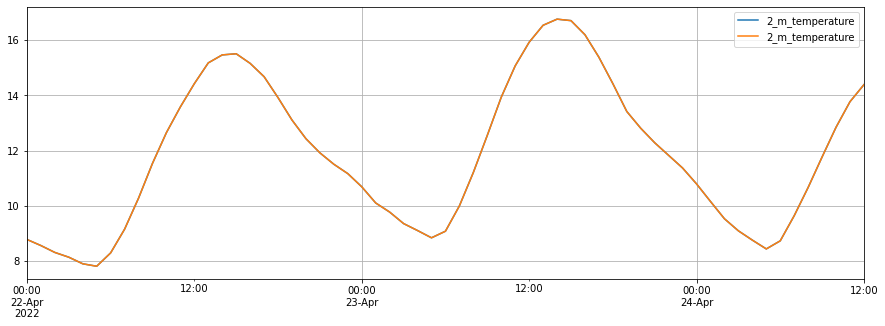

In [21]:
fix, ax = plt.subplots(figsize=(15,5))
df.plot(ax=ax)
df_lamb.plot(ax=ax)
ax.grid()

## Example: Compare measurements and 

We can also use the package to compare measurements from AWS with the model forecasts.

First we use the package to check the stations and parameters for which we have data available

In [23]:
aws = AWS()

In [24]:
stations = aws.get_stations()
stations

,code,the_geom,altitude,name,date_begin,date_end
3,6418,POINT (51.347375 3.201846),12.1,ZEEBRUGGE,2017-11-18T00:00:00,NaN
19,6472,POINT (50.193663 5.255236),295.3,HUMAIN,2017-11-18T00:00:00,NaN


In [25]:
aws.get_parameters()

{'code': 'int',
 'timestamp': 'dateTime',
 'air_pressure': 'decimal',
 'air_temperature': 'decimal',
 'relative_humidity': 'decimal',
 'precipitation': 'decimal',
 'wind_speed': 'decimal',
 'qc_flags': 'string'}

Next fetch the measurement and forecast data for Humain for one of the parameters (e.g. relative humidity)

In [42]:
df_meas = aws.get_data('6472', start_date=(datetime.now() - timedelta(hours=24)).isoformat(), parameter_list=['relative_humidity'])

In [41]:
df_fc = kmi.get_data('Relative_humidity', 5.255236, 50.193663 )

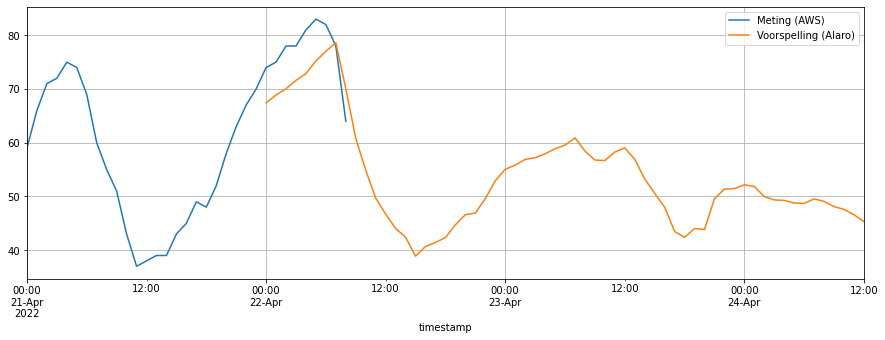

In [44]:
fix, ax = plt.subplots(figsize=(15,5))
df_meas.plot(ax=ax)
df_fc.plot(ax=ax)
ax.legend(['Meting (AWS)', 'Voorspelling (Alaro)'])
ax.grid()